In [ ]:
# outcome probability model for fastballs

In [51]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mysql.connector
import pybaseball
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
# pull statcast data for the 2023 season

df1 = pybaseball.statcast(start_dt='2022-03-30', end_dt='2022-04-30')
df2 = pybaseball.statcast(start_dt='2022-05-01', end_dt='2022-05-31')
df3 = pybaseball.statcast(start_dt='2022-06-01', end_dt='2022-06-30')
df4 = pybaseball.statcast(start_dt='2022-07-01', end_dt='2022-07-31')
df5 = pybaseball.statcast(start_dt='2022-08-01', end_dt='2022-08-31')
df6 = pybaseball.statcast(start_dt='2022-09-01', end_dt='2022-09-30')
df7 = pybaseball.statcast(start_dt='2022-10-01', end_dt='2022-11-05')

# combine dfs and save as csv

df = pd.concat([df1, df2, df3, df4, df5, df6, df7])
df.to_csv('2022_MLB_Season.csv')

This is a large query, it may take a moment to complete


100%|██████████| 32/32 [00:25<00:00,  1.24it/s]


This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:28<00:00,  1.07it/s]


This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:28<00:00,  1.07it/s]


This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


This is a large query, it may take a moment to complete


100%|██████████| 36/36 [00:14<00:00,  2.47it/s]


In [64]:
# use this if rerunning

df = pd.read_csv('2022_MLB_Season.csv')

In [65]:
# convert batter handedness columns to binary

encoder = LabelEncoder()
df['stand'] = encoder.fit_transform(df['stand'])

# generate unique id column

df['pitch_id'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs

df = df[df['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

In [66]:
# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df['spin_axis'] = 360 - df['spin_axis']

In [67]:
# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [68]:
# create outcome column using events and description columns

description_mapping = {
    'ball': 'ball',
    'hit_by_pitch': 'ball',
    'blocked_ball': 'ball',
    'swinging_strike': 'whiff',
    'missed_bunt': 'whiff',
    'swinging_strike_blocked': 'whiff',
    'foul_bunt': 'foul',
    'foul': 'foul',
    'foul_tip': 'foul',
    'bunt_foul_tip': 'foul',
    'called_strike': 'called_strike'
}

events_mapping = {
    'fielders_choice': 'out',
    'field_out': 'out',
    'force_out': 'out',
    'field_error': 'out',
    'grounded_into_double_play': 'out',
    'sac_fly': 'out',
    'fielders_choice_out': 'out',
    'sac_bunt': 'out',
    'double_play': 'out',
    'sac_fly_double_play': 'out',
    'other_out': 'out',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'
}

df['outcome'] = np.where(
    df['description'] != 'hit_into_play',
    df['description'].map(description_mapping),
    df['events'].map(events_mapping)
)

df.dropna(subset=['outcome'], inplace=True)

df['outcome'] = encoder.fit_transform(df['outcome'])


In [69]:
# feature selection and data splitting

features = ['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio']

# create features and targets

X = df[features]
y = df['outcome']

# train valid test split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [70]:
# set up model
# change num_class once we have other pitch features

model = xgb.XGBClassifier(objective='multi:softmax', num_class=9, eval_metric='mlogloss', use_label_encoder=False)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=9, num_parallel_tree=None, objective='multi:softmax', ...)

In [71]:
# make predictions

y_pred = model.predict(X_test)

# evaluate the model

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.3355556096255383
Confusion Matrix:
[[13503   141     0   223     0    22     2     0    23]
 [ 7106    98     0    97     0    10     0     0     5]
 [  455     3     0     5     0     0     0     0     1]
 [ 8610    73     1   166     0    12     0     0    23]
 [  323     4     0     3     0     1     0     0     0]
 [ 4919    53     0    84     0    13     0     0    11]
 [ 1454    23     0    25     0     2     0     0     3]
 [   26     1     0     0     0     0     0     0     0]
 [ 3445    23     0    89     1     5     1     0    11]]


<Figure size 1000x2000 with 0 Axes>

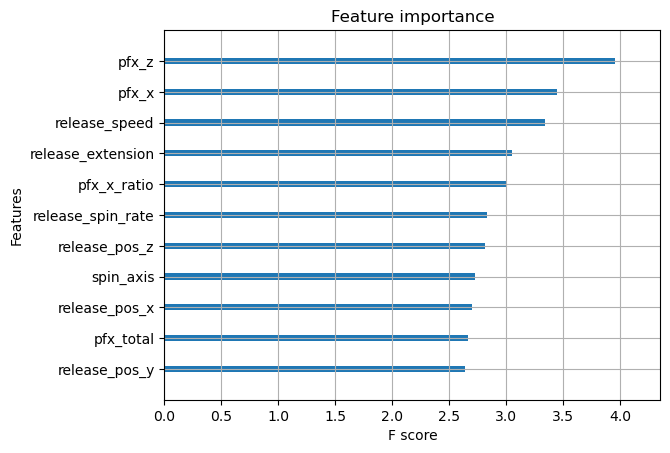

In [75]:
# plot feature importances

plt.figure(figsize=(10, 20))
xgb.plot_importance(model, max_num_features=None, importance_type='gain', show_values=False)
plt.savefig('feature_importance.png')
plt.show()

In [80]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

pfx_z: 3.956979274749756
pfx_x: 3.4469799995422363
release_speed: 3.3438398838043213
release_extension: 3.053359270095825
pfx_x_ratio: 3.010190725326538
release_spin_rate: 2.8266358375549316
release_pos_z: 2.811767101287842
spin_axis: 2.7238690853118896
release_pos_x: 2.69822096824646
pfx_total: 2.665687322616577
release_pos_y: 2.6399037837982178


In [ ]:
# get run value for each event type